# Imports

In [1]:
import socket
import threading
from concurrent.futures import ThreadPoolExecutor
import time
import numpy as np
import pandas as pd
from typing import Callable
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

_ = sns.set_style('whitegrid')

# Send single request (no concurrency)

In [2]:
def send_request_with_socket(message: str, socket: socket.socket, host: str = 'localhost', port: int = 6160):
    """Send request with payload {message} through {socket} to server listening on {host}:{port}."""
    sock.sendto(f'{message}\n'.encode(), (host, port))
    response, _ = sock.recvfrom(1024)
    # print(response)
    return response

In [3]:
# instantiate udp socket
sock: socket.socket = socket.socket(family=socket.AF_INET, type=socket.SOCK_DGRAM)

In [4]:
%%timeit
send_request_with_socket(message='sent from the script', socket=socket.socket)

105 μs ± 9.83 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Send concurrent requests

In [5]:
def run_concurrent_requests(num_requests: int, f_send: Callable) -> float:
    """Run {num_requests} concurrent requests via {f_send}."""
    start = time.perf_counter()
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(f_send, range(num_requests)))
        end = time.perf_counter()
        elapsed_ms = (end - start) * 1000
        return elapsed_ms
        

n_loops = 10
n_threads = 3
num_requests = np.array([0] + [(x+1) * n_threads for x in range(15)]) + 1
num_requests = range(1, 45+1)

In [6]:
n_jobs = 1
sock: socket.socket = socket.socket(family=socket.AF_INET, type=socket.SOCK_DGRAM)
f_send = partial(send_request_with_socket, socket=sock)
elapsed_times_njobs_1 = [(n, n_jobs, run_concurrent_requests(num_requests=n, f_send=f_send)) for n in num_requests for _ in range(n_loops)]

In [7]:
n_jobs = -1
sock: socket.socket = socket.socket(family=socket.AF_INET, type=socket.SOCK_DGRAM)
f_send = partial(send_request_with_socket, socket=sock)
elapsed_times_njobs_all = [(n, n_jobs, run_concurrent_requests(num_requests=n, f_send=f_send)) for n in num_requests for _ in range(n_loops)]

# Plot elapsed times

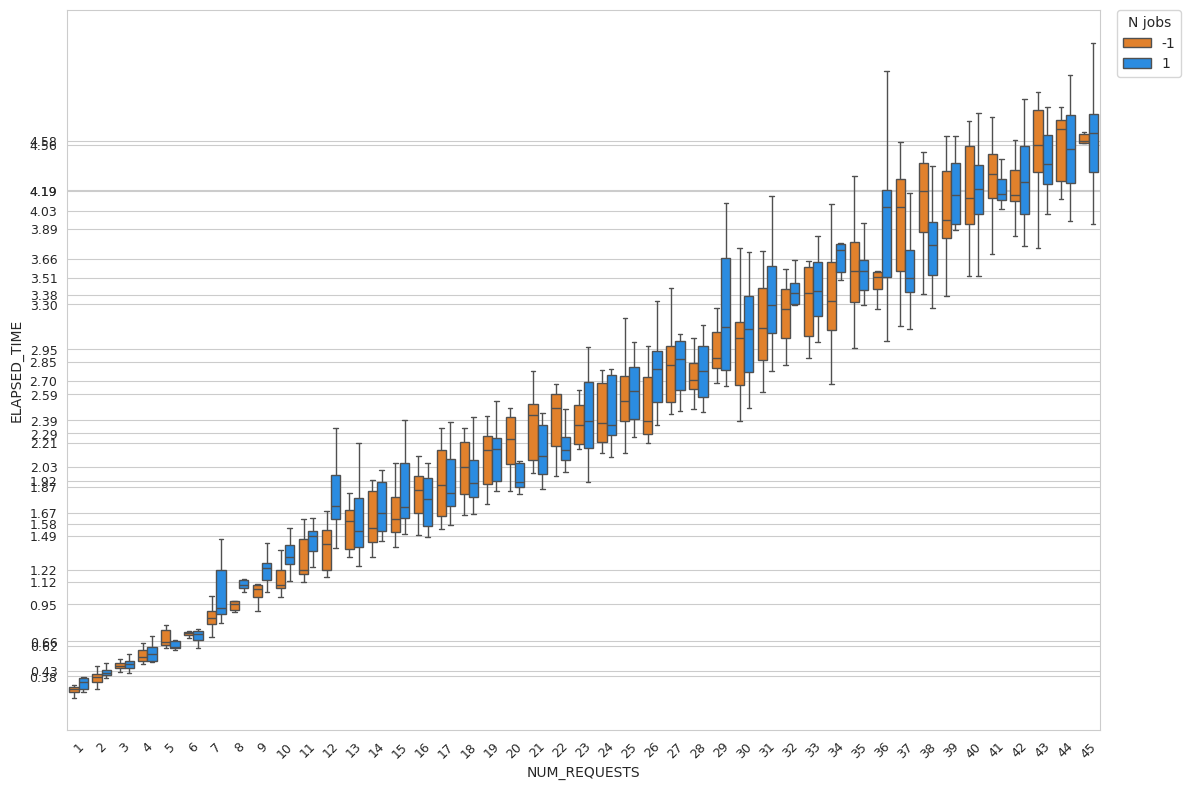

In [8]:
df_plot = pd.DataFrame(elapsed_times_njobs_1+elapsed_times_njobs_all, columns=['NUM_REQUESTS', 'N_JOBS', 'ELAPSED_TIME'])

medians = []
ds_medians = df_plot.groupby('NUM_REQUESTS')['ELAPSED_TIME'].median().sort_index().reset_index()
for n_ in [1, -1]:
    for min_, max_ in list(zip(
        (np.array([0] + [(x+1) * n_threads for x in range(45//3)])+1),
        (np.array([0] + [(x+1) * n_threads for x in range(45//3)])+1)[1:]
    )):
        medians.append(df_plot.query(f"NUM_REQUESTS >= {min_} & N_JOBS == {n_} & NUM_REQUESTS < {max_}")['ELAPSED_TIME'].median())

custom_palette = {
    1: '#0D8EFF',     # blue
    -1: '#ff7f0e',    # orange
}
f, ax = plt.subplots(1, 1, figsize=(12, 8))
_ = sns.boxplot(x='NUM_REQUESTS', y='ELAPSED_TIME', hue='N_JOBS', palette=custom_palette, showfliers=False, data=df_plot, ax=ax)
_ = ax.set_yticks(medians, [f"{m:.2f}" for m in medians])
_ = plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.01), title='N jobs')
_ = plt.xticks(rotation=45, fontsize=9)
_ = plt.yticks(fontsize=9)
_ = plt.tight_layout()
_ = plt.show()